In [282]:
from pandas_datareader import data
import matplotlib.pyplot as plt
import pandas as pd
import datetime


In [308]:
# Define the instruments to download. We would like to see Apple, Microsoft and the S&P500 index.
tickers = ['AAPL', 'MSFT', '^GSPC']

# We would like all available data from 10 month back (approx ~) 

end_date = datetime.datetime.now()
start_date = end_date - datetime.timedelta(days=(30 * 10))

# User pandas_reader.data.DataReader to load the desired data. As simple as that.
df = data.DataReader('AAPL', 'yahoo', start_date, end_date)

In [302]:
df.shape

(208, 6)

In [303]:
close = df['Close']
close_px = df['Adj Close']
mavg = close_px.rolling(window=100).mean()
all_weekdays = pd.date_range(start=start_date, end=end_date, freq='B')
close = close.reindex(all_weekdays)
close = close.fillna(method='ffill')

In [305]:
close.head(10)

2019-04-22 23:30:04.404027   NaN
2019-04-23 23:30:04.404027   NaN
2019-04-24 23:30:04.404027   NaN
2019-04-25 23:30:04.404027   NaN
2019-04-26 23:30:04.404027   NaN
2019-04-29 23:30:04.404027   NaN
2019-04-30 23:30:04.404027   NaN
2019-05-01 23:30:04.404027   NaN
2019-05-02 23:30:04.404027   NaN
2019-05-03 23:30:04.404027   NaN
Freq: B, Name: Close, dtype: float64

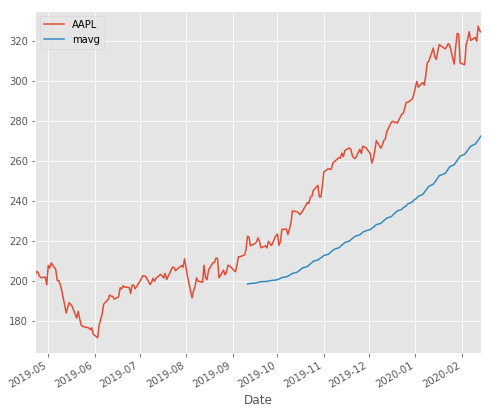

In [306]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import style

# Adjusting the size of matplotlib
import matplotlib as mpl
mpl.rc('figure', figsize=(8, 7))
mpl.__version__

# Adjusting the style of matplotlib
style.use('ggplot')

close_px.plot(label='AAPL')
mavg.plot(label='mavg')
plt.legend()

In [288]:
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor

from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

In [289]:
dfreg = df.loc[:,['Adj Close','Volume']]
dfreg['HL_PCT'] = (df['High'] - df['Low']) / df['Close'] * 100.0
dfreg['PCT_change'] = (df['Close'] - df['Open']) / df['Open'] * 100.0
dfreg.head()

,Adj Close,Volume,HL_PCT,PCT_change
Date,,,,
2019-04-22,201.887497,19439500.0,1.271210,0.838139
2019-04-23,204.799362,23323000.0,1.855604,1.491955
2019-04-24,204.483505,17540600.0,0.690284,-0.096449
2019-04-25,202.627808,18543200.0,1.286048,-0.749409
2019-04-26,201.660461,18649100.0,1.409694,-0.292821


In [290]:
import math
import numpy as np
from sklearn import preprocessing, svm
from sklearn.model_selection import train_test_split


# Drop missing value
dfreg.fillna(value=-99999, inplace=True)

print(dfreg.shape)
# We want to separate 1 percent of the data to forecast
forecast_out = int(math.ceil(0.01 * len(dfreg)))

# Separating the label here, we want to predict the AdjClose
forecast_col = 'Adj Close'
dfreg['label'] = dfreg[forecast_col].shift(-forecast_out)
X = np.array(dfreg.drop(['label'], 1))

# Scale the X so that everyone can have the same distribution for linear regression
X = preprocessing.scale(X)

# Finally We want to find Data Series of late X and early X (train) for model generation and evaluation
# X_lately = X[-forecast_out:]
X_lately = X[-forecast_out:]
X = X[:-forecast_out]

# Separate label and identify it as y
y = np.array(dfreg['label'])
y = y[:-forecast_out]

print('Dimension of X',X.shape)
print('Dimension of y',y.shape)
dfreg.head(5)
X_lately.shape

(208, 4)
Dimension of X (205, 4)
Dimension of y (205,)


(3, 4)

In [291]:
forecast_out

3

In [292]:
# Temp Space
int(math.ceil(0.001 * len(dfreg)))

1

In [293]:
# Separation of training and testing of model by cross validation train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [294]:
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor

from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

# Linear regression
clfreg = LinearRegression(n_jobs=-1)
clfreg.fit(X_train, y_train)


# Quadratic Regression 2
clfpoly2 = make_pipeline(PolynomialFeatures(2), Ridge())
clfpoly2.fit(X_train, y_train)

# Quadratic Regression 3
clfpoly3 = make_pipeline(PolynomialFeatures(3), Ridge())
clfpoly3.fit(X_train, y_train)
    
# KNN Regression
clfknn = KNeighborsRegressor(n_neighbors=2)
clfknn.fit(X_train, y_train)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=2, p=2,
                    weights='uniform')

In [295]:
X_train.shape

(164, 4)

In [296]:
confidencereg = clfreg.score(X_test, y_test)
confidencepoly2 = clfpoly2.score(X_test,y_test)
confidencepoly3 = clfpoly3.score(X_test,y_test)
confidenceknn = clfknn.score(X_test, y_test)

print("The linear regression confidence is ",confidencereg)
print("The quadratic regression 2 confidence is ",confidencepoly2)
print("The quadratic regression 3 confidence is ",confidencepoly3)
print("The knn regression confidence is ",confidenceknn)

The linear regression confidence is  0.9845421454739991
The quadratic regression 2 confidence is  0.9845834494345234
The quadratic regression 3 confidence is  0.9774570273871213
The knn regression confidence is  0.8983101602836295


In [297]:
# Printing the forecast
forecast_set = clfpoly3.predict(X_lately)
dfreg['Forecast'] = np.nan
# print(forecast_set, confidencereg, forecast_out)

In [298]:
dfreg.iloc[-1].name

Timestamp('2020-02-14 00:00:00')

In [299]:
last_date = dfreg.iloc[-1].name
last_unix = last_date
next_unix = last_unix + datetime.timedelta(days=1)

for i in forecast_set:
    next_date = next_unix
    next_unix += datetime.timedelta(days=1)
    dfreg.loc[next_date] = [np.nan for _ in range(len(dfreg.columns)-1)]+[i]
    

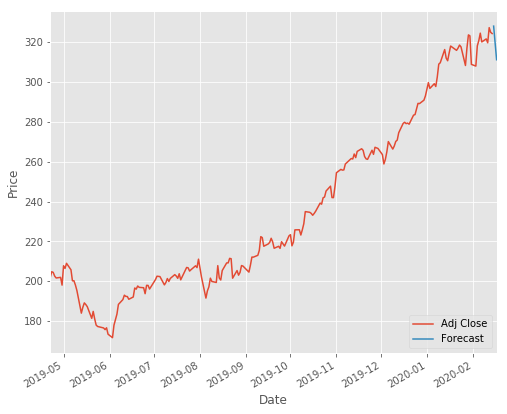

In [300]:

dfreg['Adj Close'].tail(500).plot()
dfreg['Forecast'].tail(500).plot()
plt.legend(loc=4)
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()